In [10]:
import numpy as np
from network import Network
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits import mplot3d
import metrics

plt.rcParams.update({'font.size': 20})
plt.rc('figure', figsize=(20, 10))
plt.rc('figure', facecolor=(1,1,1,1))


## Ejercicio 2

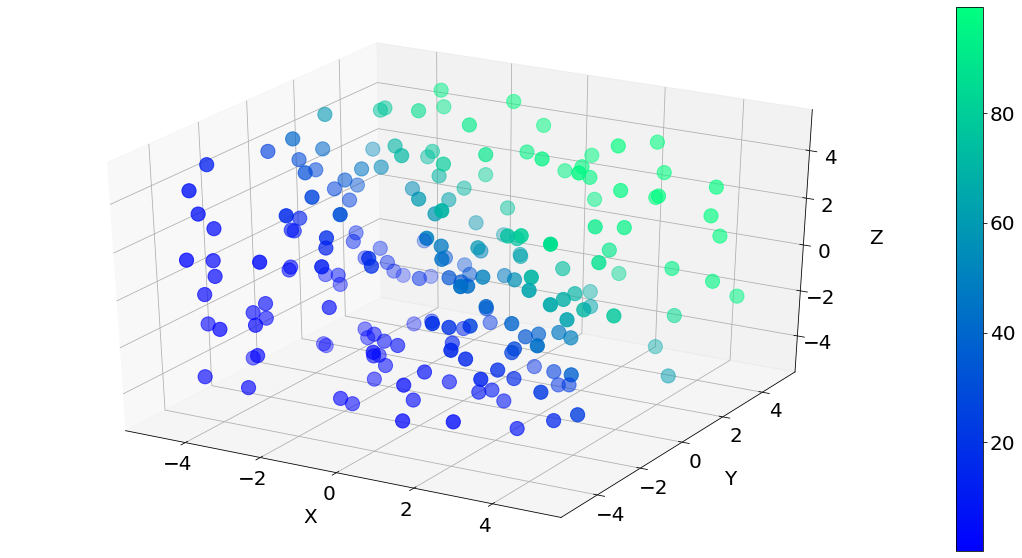

In [11]:
from datasets import training_dataset_2

expected = [y[0] for x, y in training_dataset_2]

max_value = max(expected)
min_value = min(expected)

delta = (max_value - min_value)/2

normalized = []

for (x, y), v in zip(training_dataset_2, expected):
    e = (v - min_value)/delta - 1
    normalized.append((x, [e]))


def plot3d(X,Y,Z, c, min = min_value, max = max_value, map="winter"):
    ax = plt.axes(projection='3d')
    s = ax.scatter3D(X, Y, Z, c=c, cmap=map, s=200, vmin=min, vmax=max)
    ax.set_xlabel('X', labelpad=20)
    ax.set_ylabel('Y', labelpad=20)
    ax.set_zlabel('Z', labelpad=20)
    plt.colorbar(s)


plt.figure("Dataset 2")

X = [x[0][0] for x in training_dataset_2]
Y = [x[0][1] for x in training_dataset_2]
Z = [x[0][2] for x in training_dataset_2]
C = [x[1][0] for x in training_dataset_2]

plot3d(X,Y,Z, C)

plt.show()


### Lineal

Error: 46.44223921665171
Epochs: 100


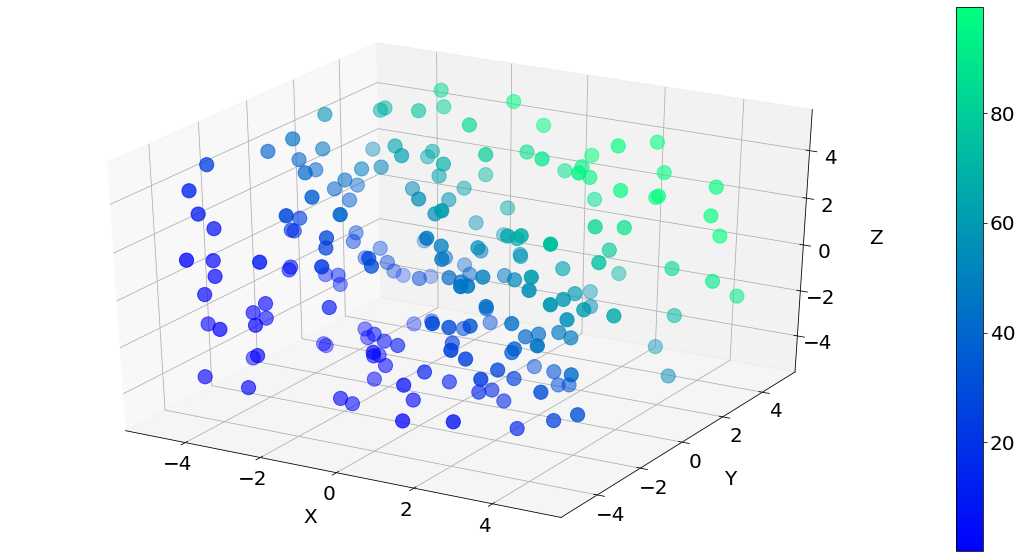

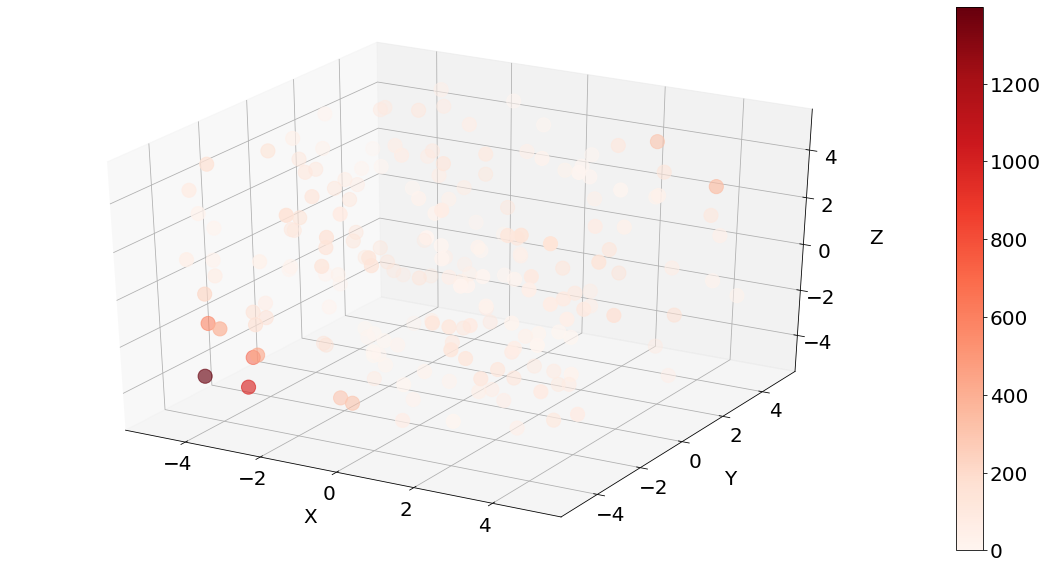

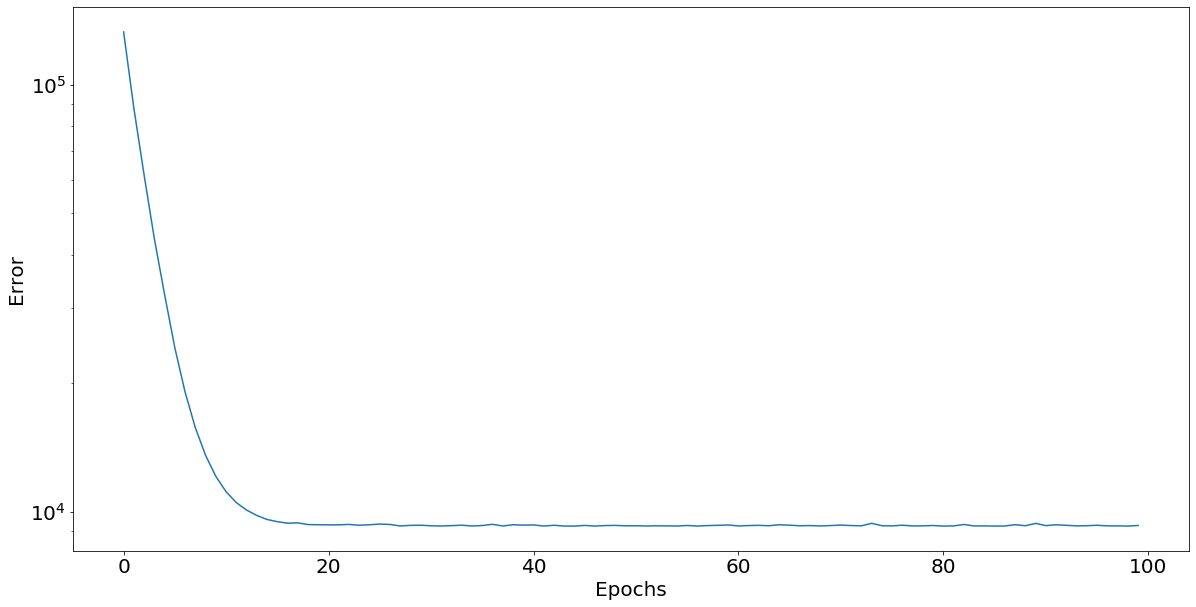

In [12]:
network = Network(structure=[3, 1],
                  activation='lineal', seed=17, args={'b': 0.8})
errors = network.train(training_dataset_2, batch_size=1,
                       epochs=100, learning_rate=0.001, momentum=0.4)

print("Error:", errors[-1]/len(training_dataset_2))
print("Epochs:", len(errors))

plt.figure("Lineal network")

c = np.array([network.feedforward(x)[0] for x, y in training_dataset_2])

plot3d(X, Y, Z, c)

plt.show()

plt.figure("Lineal error heatmap")
err = (c-C)**2
max_error = max(err)
plot3d(X, Y, Z, err, min=0, max=max_error, map="Reds")


plt.figure("Lineal error")
plt.yscale('log')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.plot(errors)
plt.show()


### No lineal

Error: 2.9087231877876385
Epochs: 100


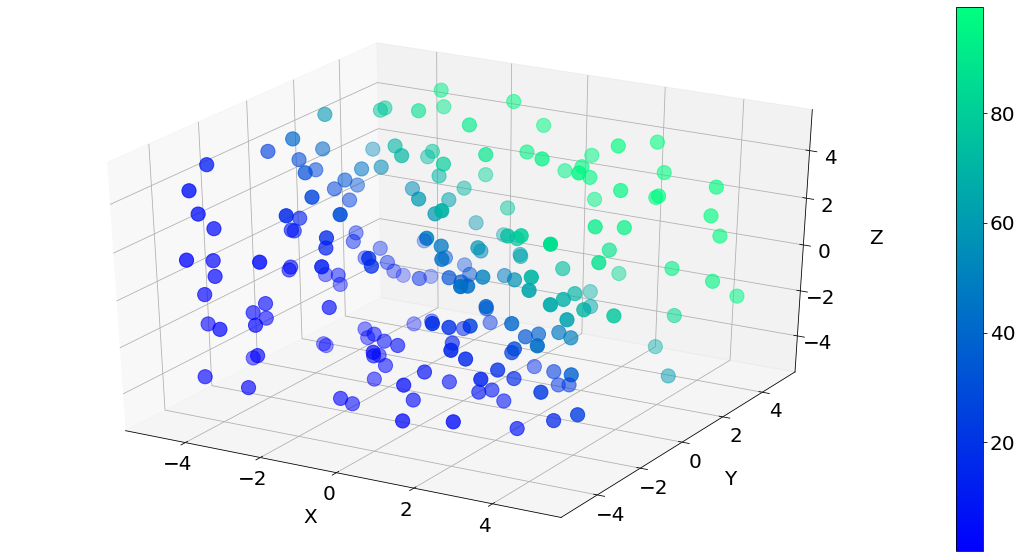

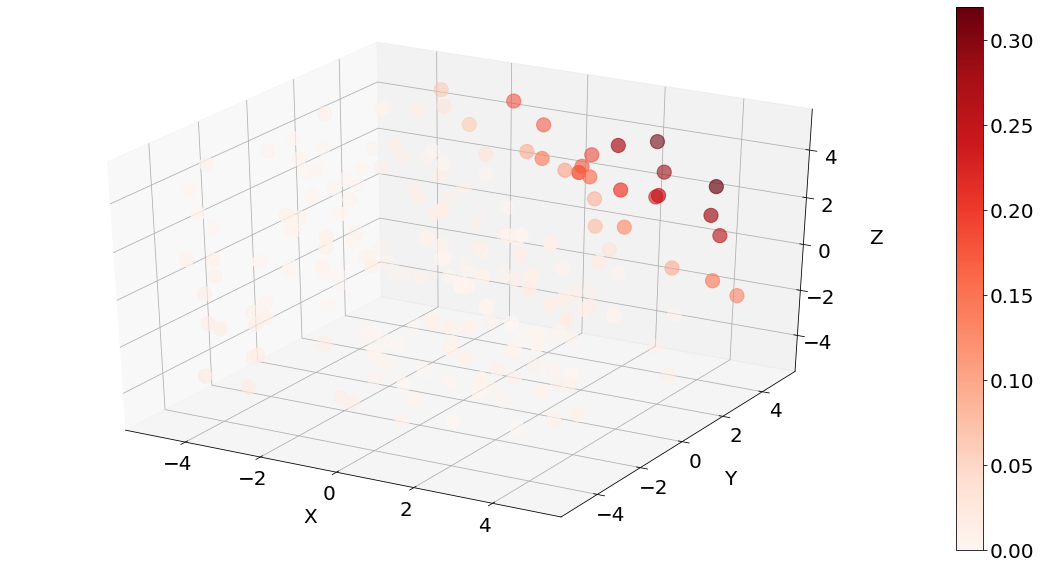

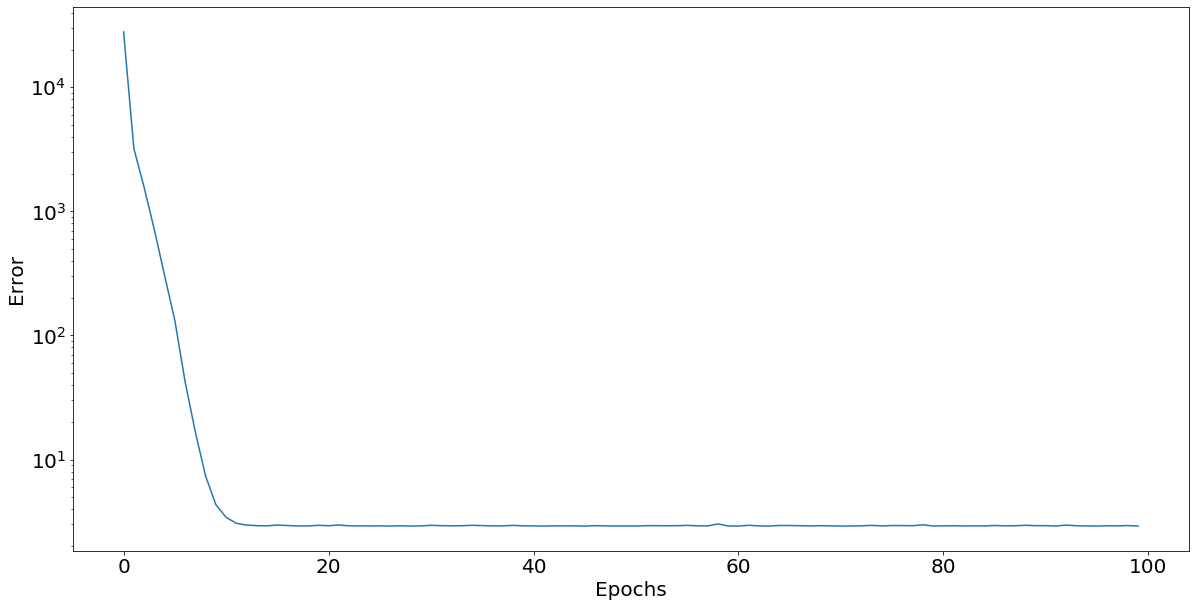

In [13]:
network = Network(structure=([3, 1]), activation='tanh', seed=17)
errors = network.train(normalized, epochs=100, learning_rate=0.01, momentum=0)
errors = np.array(errors)*delta**2
print("Error:", errors[-1])
print("Epochs:", len(errors))

plt.figure("no lineal network")

c = np.array([network.feedforward(x)[0] for x, y in training_dataset_2])

c = (c+1)*delta + min_value

plot3d(X,Y,Z, c)

plt.show()

plt.figure("no Lineal error heatmap")



err = (c-C)**2
plot3d(X, Y, Z, err, min=0, max=max(err), map="Reds")


plt.figure("Non-lineal error")
plt.yscale('log')
plt.plot(errors)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()


### Comparison

Error: 1.03998975700617


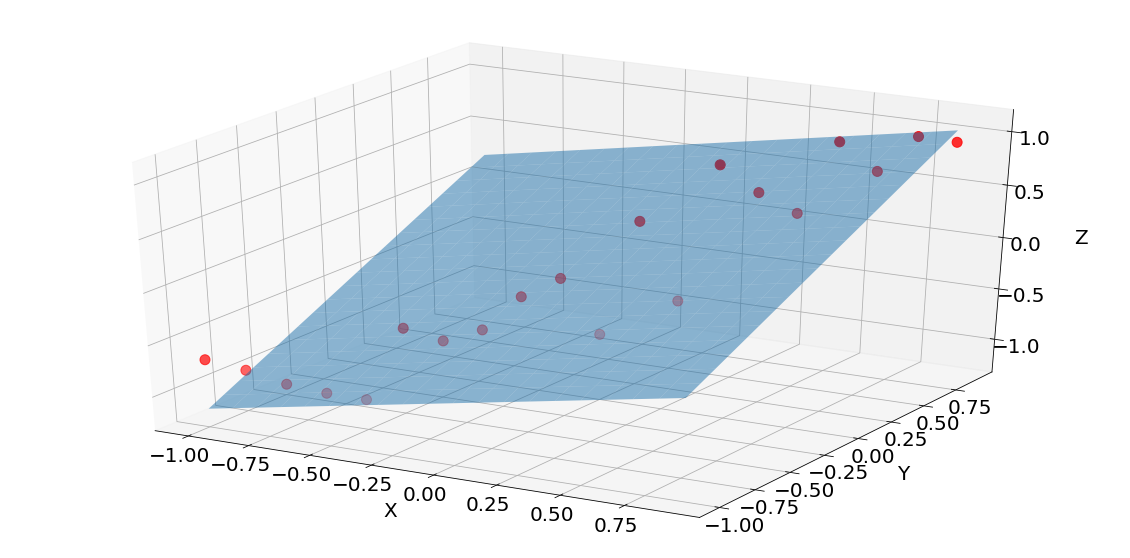

Error: 0.8187283022934176


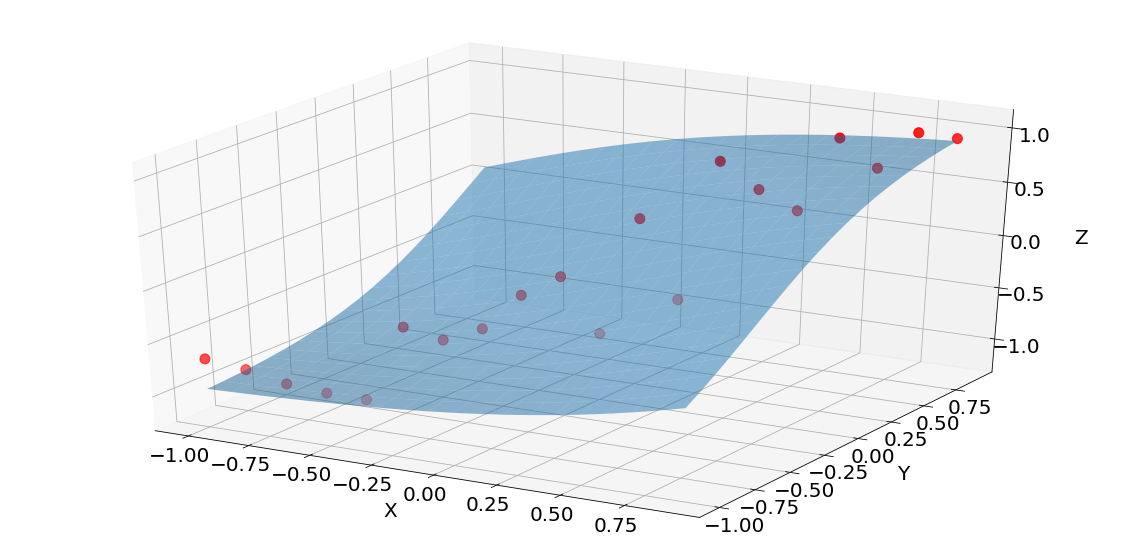

In [14]:
X = np.arange(-1,1, 0.1)
Y = np.arange(-1,1, 0.1)
Z = np.arange(-1,1, 0.1)

rng =np.random.default_rng(17)

randoms = rng.normal(0,0.3, Z.shape)

Z += randoms

dataset = [ ([x,y],[z]) for x,y,z in zip(X,Y,Z) ]

activations = ['lineal', 'tanh']


for activation in activations:
    network = Network(structure=[2,1], activation=activation, seed=3)
    errors = network.train(dataset, epochs=100)
    print("Error:", errors[-1])

    plt.figure("transformation {}".format(activation))
    ax = plt.axes(projection='3d')


    ax.scatter3D(X, Y, Z, c="red", s=100)

    XP,YP = np.meshgrid(X,Y)

    O = np.zeros((len(X), len(Y)))

    for i,(r1,r2) in enumerate(zip(XP,YP)):
        for j,(x,y) in enumerate(zip(r1,r2)):
            z = network.feedforward([x,y])[0]
            O[i][j] = z




    ax.plot_surface(XP, YP, O, alpha=0.5)
    ax.set_xlabel('X', labelpad=20)
    ax.set_ylabel('Y', labelpad=20)
    ax.set_zlabel('Z', labelpad=20)
    plt.show()

### Metrics

Precision test set:  0.7
Precision for training set:  0.70625


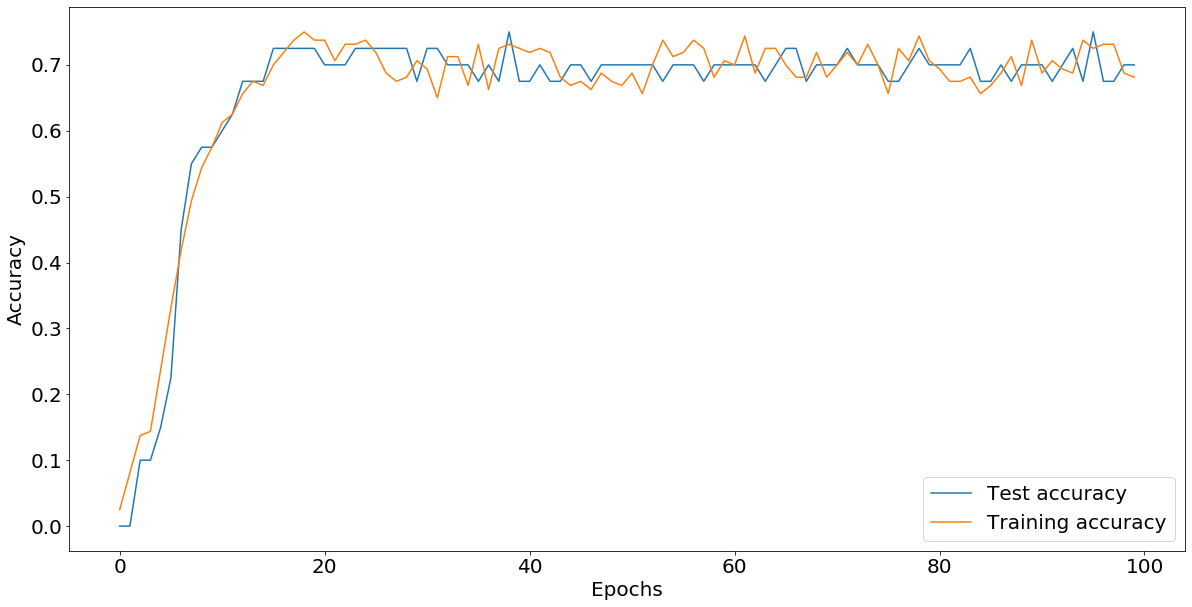

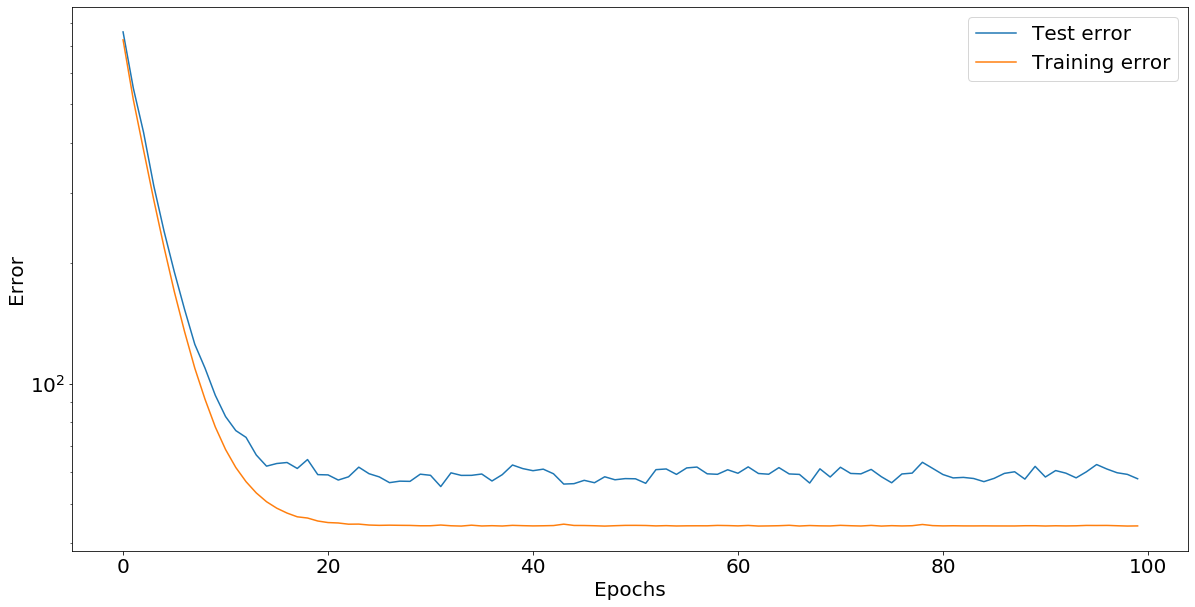

In [15]:
network_template = Network(structure=([3, 1]),
                  activation='lineal', seed=17, args={'b': 0.8})    
epsilon = 10
lr = 0.001       
network,precision,precision_training,test,training = metrics.cross_validation(training_dataset_2, network_template, k=5,  epochs=100, metric = lambda n,d: metrics.accuracy(n,d,epsilon),lr=lr,m=0)
print("Precision test set: ",precision)
print("Precision for training set: ",precision_training)

test_acuracy = []
test_errors = []
training_acuracy = []
def callback(network):
    test_acuracy.append(metrics.accuracy(network,test,epsilon))
    test_errors.append(network.error(test))
    training_acuracy.append(metrics.accuracy(network,training,epsilon))

errors = network_template.train(training, epochs=100, learning_rate=lr, momentum=0.4, epoch_callback=callback)

plt.figure("Accuracy Lineal")
plt.plot(test_acuracy, label="Test accuracy")
plt.plot(training_acuracy, label="Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure("Error Lineal")
plt.plot(np.array(test_errors)/len(test), label="Test error")
plt.plot(np.array(errors)/len(training), label="Training error")
plt.yscale('log')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.show()

Precision test set:  0.925
Precision for training set:  0.85625


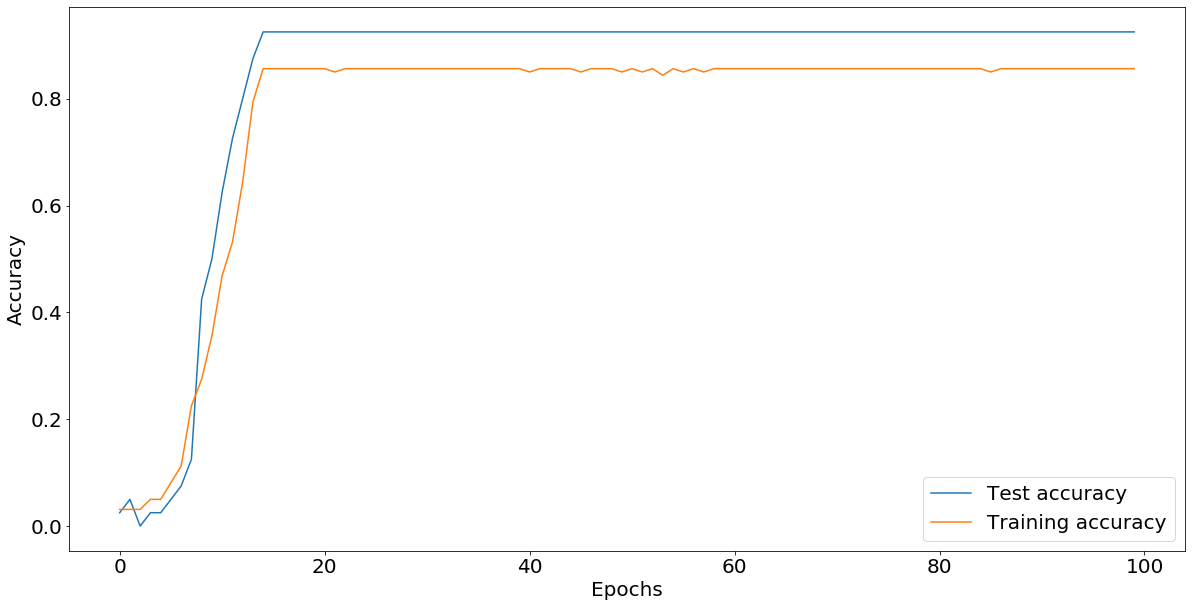

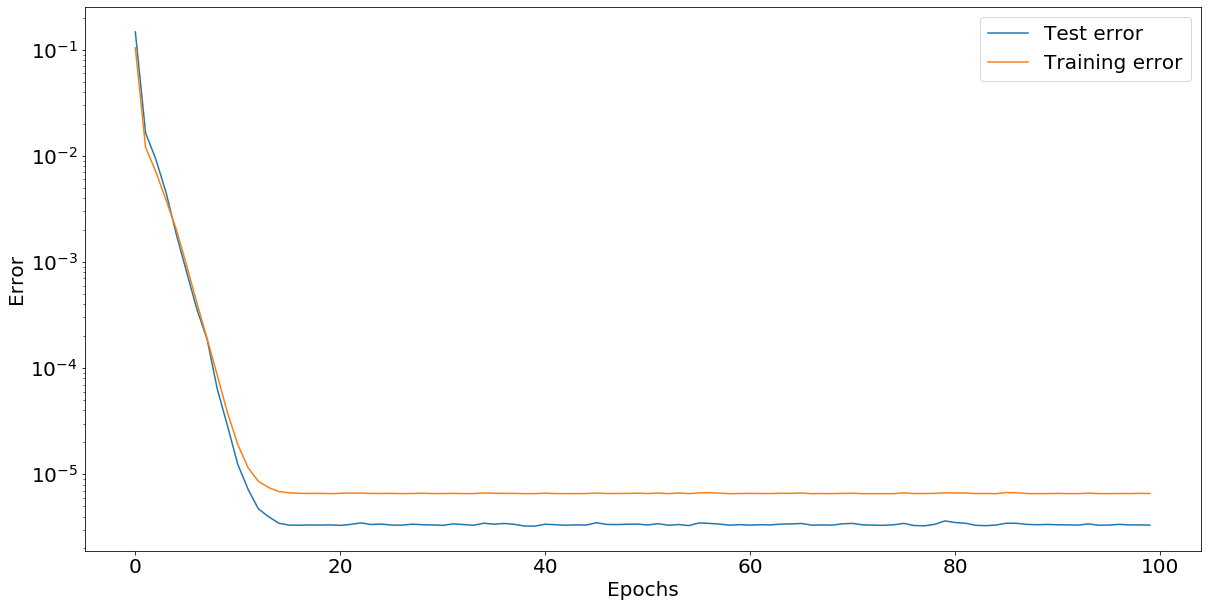

In [16]:
network_template = Network(structure=([3, 1]), activation='tanh', seed=17)

epsilon2 = epsilon/delta**2
lr = 0.01

network, precision, precision_training, test, training = metrics.cross_validation(
    normalized, network_template, k=5,  epochs=100, lr=lr, metric=lambda n, d: metrics.accuracy(n, d, epsilon2))
print("Precision test set: ", precision)
print("Precision for training set: ", precision_training)


test_acuracy = []
test_errors = []
training_acuracy = []


def callback(network):
    test_acuracy.append(metrics.accuracy(network, test, epsilon2))
    test_errors.append(network.error(test))
    training_acuracy.append(metrics.accuracy(network, training, epsilon2))


errors = network_template.train(
    training, epochs=100, learning_rate=lr, momentum=0, epoch_callback=callback)


plt.figure("Accuracy non Lineal")
plt.plot(test_acuracy, label="Test accuracy")
plt.plot(training_acuracy, label="Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure("Error non Lineal")
plt.plot(np.array(test_errors)/len(test), label="Test error")
plt.plot(np.array(errors)/len(training), label="Training error")
plt.yscale('log')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.show()





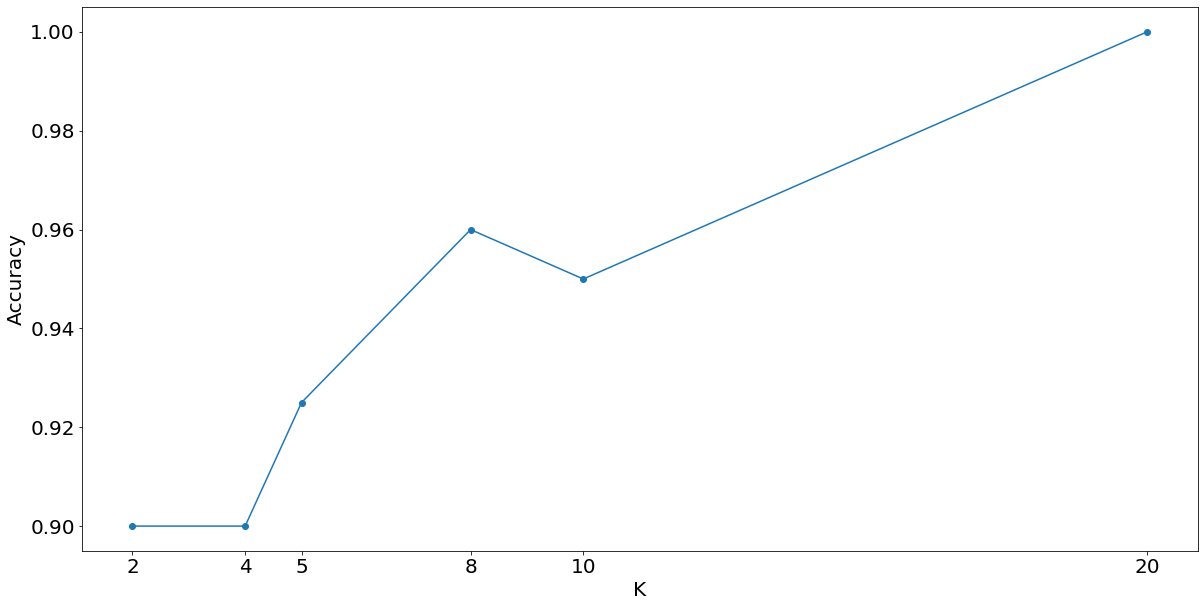

In [17]:
network_template = Network(structure=([3, 1]), activation='tanh', seed=17)

epsilon2 = epsilon/delta**2
lr = 0.01
test_acuracy = []
k = [2,4,5,8,10,20]
for i in range(len(k)):
    network, precision, precision_training, test, training = metrics.cross_validation(
        normalized, network_template, k=k[i],  epochs=50, lr=lr, metric=lambda n, d: metrics.accuracy(n, d, epsilon2))
    test_acuracy.append(precision)


plt.figure("Accuracy non Lineal k")
plt.plot(k,test_acuracy,"o-")
plt.xlabel("K")
plt.xticks(k)
plt.ylabel("Accuracy")
plt.show()
